# Improving Content Based Image Retrieval through Image Segmentation

This demo will take a user given image, segment it and compare the results of the Content Based Image Retrieval system using the original and the segmented image.

## 1. Dataset

We prepare the dataset used for this research

In [31]:
import cv2
import numpy as np
import os
import sys

root = os.path.abspath("./")

### COCO

We will use the COCO validation dataset and use the cocoapi to extract information from the annotations.
Download the images from the [COCO](http://cocodataset.org/#download) website and extract it to the datasets folder.
Then at the cocoapi [repo](https://github.com/philferriere/cocoapi), follow the installation instructions

In [32]:
MODEL_FOLDER = "models"
DATASET_FOLDER = "datasets"
FEATURES_FOLDER = "features"

SUBSET = 'val'
YEAR = '2017'

RESIZED = False

In [33]:
sys.path.append(os.path.join(root, "cocoapi/"))
from pycocotools.coco import COCO
import coco

# initialize COCO api for instance annotations
dataset = coco.CocoDataset()
coco_dat = dataset.load_coco(dataset_dir=DATASET_FOLDER, subset=SUBSET, year=YEAR, return_coco=True, auto_download=True)
dataset.prepare() 

Will use images in datasets/val2017
Will use annotations in datasets/annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [34]:
# display COCO categories and supercategories
cats = coco_dat.loadCats(coco_dat.getCatIds())
catnms=[cat['name'] for cat in cats]
print('{} COCO categories: \n{}\n'.format(len(catnms), ' '.join(catnms)))


supnms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(supnms)))

80 COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
vehicle electronic kitchen appliance animal person accessory food furniture outdoor sports indoor


### Feature Database
The features are stored in a hd5f database which allows for easy search and retrieval

In [35]:
from utils import Database

RESIZE = 299
FEATURES_DB = '{0}/{1}{2}.hdf5'.format(FEATURES_FOLDER, SUBSET, YEAR)
print('Saving features to {}'.format(FEATURES_DB))

database = Database(FEATURES_DB)

Saving features to features/val2017.hdf5


Create the database

In [36]:
# database.create(FEATURES_DB, '{0}/{1}{2}'.format(DATASET_FOLDER, SUBSET, YEAR))

## 2. Feature Extraction
Extract the image features from the dataset using a pretrained model (vgg16, vgg19, inception or resnet)

### Local Binary Patterns
Local Binary Patterns are used to detect intensity changes over an image. This can then be used to detect textural features of an image.

In [37]:
from utils import LocalBinaryPatterns

lbp = LocalBinaryPatterns(24,8)

# lbp.dump_features(hdf5_path=FEATURES_DB, resized=RESIZED, resize=RESIZE)
print('Features Dumped succesfully')

Features Dumped succesfully


### Color Moments

In [38]:
from utils import Color

color = Color()

# color.dump_features(hdf5_path=FEATURES_DB, resized=RESIZED, resize=RESIZE)
print('Features Dumped succesfully')

Features Dumped succesfully


## 3. Image Segmentation

This program will use Facebooks's [Mask-RCNN](https://github.com/matterport/Mask_RCNN) convolutional neural network, to segment a given image and give the bounding boxes of those segments.

In [39]:
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize


COCO_MODEL_PATH = '{}/{}'.format(MODEL_FOLDER, 'mask_rcnn_coco.h5')

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [40]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [41]:
# Create model object in inference mode.
print('Creating MaskRCNN object')
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_FOLDER, config=config)

# Load weights trained on MS-COCO
print('Loading weights from {}'.format(COCO_MODEL_PATH))
model.load_weights(COCO_MODEL_PATH, by_name=True)

Creating MaskRCNN object
Loading weights from models/mask_rcnn_coco.h5


### Retrieve a random image
We select a random image from the dataset and use it to match against other images and also get the classes from the image

In [42]:
# get all images containing a given supercategory, select one at random
catIds = coco_dat.getCatIds(supNms=['outdoor']);
imgIds = [coco_dat.getImgIds(catIds=i) for i in catIds]
flat_list = []
for sublist in imgIds:
    for item in sublist:
        flat_list.append(item)

id = flat_list[np.random.randint(0,len(flat_list))]

img = coco_dat.loadImgs(id)[0]

### Running Mask-RCNN on the given image
We read the randomly selected image and run the Mask-RCNN on the image to obtain the segments, masks and bounding

Running inference on datasets/val2017/000000133969.jpg


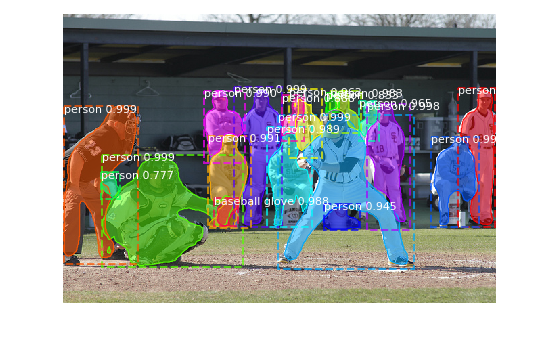

In [43]:
rand_image_name = '{0}/{1}{2}/{3}'.format(DATASET_FOLDER, SUBSET, YEAR, img['file_name'])
IMAGE = cv2.imread(rand_image_name)
if RESIZED:
    image = cv2.resize(IMAGE, (RESIZE, RESIZE))

# Run detection
print('Running inference on {}'.format(rand_image_name))
results = model.detect([IMAGE])

# Visualize results
RESULT = results[0]
visualize.display_instances(IMAGE[...,::-1], RESULT['rois'], RESULT['masks'], RESULT['class_ids'], 
                            dataset.class_names, RESULT['scores'], figsize=(8,8))

## 4. Run tests

In [44]:
RETRIEVE_NUM = 200
SHOW_NUM = 15
IDS = database.read('id')
LBP = database.read('lbp')
COL = database.read('color_moments')

GRAY = cv2.cvtColor(IMAGE, cv2.COLOR_BGR2GRAY)
HSV = cv2.cvtColor(IMAGE, cv2.COLOR_BGR2HSV)

### Feature Extraction on query image

In [45]:
from imutils import build_montages
from sklearn.metrics import pairwise_distances

original_lbp = lbp.describe(GRAY);

distances_lbp = pairwise_distances(original_lbp.reshape(1,-1), LBP)
indices_lbp = np.argsort(distances_lbp)[0][:RETRIEVE_NUM]

image_names_lbp = [IDS[index] for index in indices_lbp]
images_lbp = [cv2.imread(IDS[index]) for index in indices_lbp]
images_lbp = [cv2.resize(image, (200,200)) for image in images_lbp]

result = build_montages(images_lbp, (200, 200), (5,3))[0]
cv2.imshow("Result", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [46]:
hsv = color.process_hsv(HSV)
original_color = color.calc_moment(hsv)

distances_color = pairwise_distances(original_color.reshape(1,-1), COL)
indices_color = np.argsort(distances_color)[0][:RETRIEVE_NUM]

image_names_color = [IDS[index] for index in indices_color[:SHOW_NUM]]
images_color = [cv2.imread(IDS[index]) for index in indices_color[:SHOW_NUM]]
images_color = [cv2.resize(image, (200,200)) for image in images_color]

result = build_montages(images_color, (200, 200), (5,3))[0]
cv2.imshow("Result", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [47]:
def combine_distances(distances, weights):
    combined = np.zeros(distances.shape[-2:])
    print(combined.shape)
    for i in range(len(distances)):
        combined += distances[i] * weights[i]
    return combined

distance_combined = combine_distances(np.array([distances_lbp, distances_color]), [0.8, 0.2])
indices_combined = np.argsort(distance_combined)[0][:RETRIEVE_NUM]

image_names_combined = [IDS[index] for index in indices_combined[:SHOW_NUM]]
images_combined = [cv2.imread(IDS[index]) for index in indices_combined[:SHOW_NUM]]
images_combined = [cv2.resize(image, (200,200)) for image in images_combined]

result = build_montages(images_combined, (200, 200), (5,3))[0]
cv2.imshow("Result", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

(1, 5000)


### Feature Extraction on segmented query image

In [48]:
def extract_region(image, roi):
    return image[roi[0]:roi[2], roi[1]:roi[3]]

def join_features(features, weights):
    combined = np.zeros(features.shape[1])
    for i in range(features.shape[0]):
        combined += np.multiply(features[i], weights[i])
    return combined

In [49]:
ROIS = np.array(RESULT['rois'])
ROIS = np.vstack([ROIS, [0, 0, IMAGE.shape[0], IMAGE.shape[1]]])
print(ROIS.shape)
NUM_SEGMENTS = ROIS.shape[0]

MASKS = np.array(RESULT['masks'])
FULL_MASK = np.zeros((MASKS.shape[:2]), dtype=bool)
for i in range(MASKS.shape[2]):
    FULL_MASK = np.logical_or(FULL_MASK, MASKS[:,:,i])
MASKS = ~MASKS
test = IMAGE.copy()
MASKS = np.dstack([MASKS, FULL_MASK])

# for i in range(IMAGE.shape[0]):
#     for j in range(IMAGE.shape[1]):
#         if MASKS[i, j, 0]:
#            test[i, j] = 0

# plt.imshow(test[...,::-1])
# plt.show()

REGION_WEIGHTS = [np.count_nonzero(MASKS[:,:,i]==0) / (IMAGE.shape[0] * IMAGE.shape[1]) for i in range(NUM_SEGMENTS)]
REGION_WEIGHTS[-1] *= np.sort(REGION_WEIGHTS)[-2]
REGION_WEIGHTS = np.divide(REGION_WEIGHTS, np.sum(REGION_WEIGHTS))
print(REGION_WEIGHTS)

(19, 4)
[0.17061472 0.14987931 0.06542118 0.12392719 0.058597   0.06024491
 0.05269281 0.04689984 0.02961191 0.04834556 0.00824968 0.00982683
 0.00773408 0.01861233 0.01281936 0.00980661 0.00269934 0.00638946
 0.11762789]


In [50]:
ex_lbp = [lbp.describe(extract_region(GRAY, ROIS[i])) for i in range(NUM_SEGMENTS)]
result_ex_lbp = join_features(np.array(ex_lbp), REGION_WEIGHTS)

dists_ex_lbp = [pairwise_distances(ex_lbp[i].reshape(1,-1), LBP) for i in range(NUM_SEGMENTS)]

dists_ex_lbp_com = combine_distances(np.array(dists_ex_lbp), REGION_WEIGHTS)
dist_ex_lbp = pairwise_distances(result_ex_lbp.reshape(1,-1), LBP)

indices_ex_lbp = np.argsort(dist_ex_lbp)[0][:RETRIEVE_NUM]

images_ex_lbp = [cv2.imread(IDS[index]) for index in indices_ex_lbp]
images_ex_lbp = [cv2.resize(image, (200,200)) for image in images_ex_lbp]
image_names_ex_lbp = [IDS[index] for index in indices_ex_lbp]

result = build_montages(images_ex_lbp, (200, 200), (5,3))[0]
cv2.imshow("Result", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

(1, 5000)


In [51]:
# print(MASKS[0].shape)
ex_proc_hsv = [color.process_hsv(HSV, MASKS[:, :, i]) for i in range(NUM_SEGMENTS)]
ex_color = [color.calc_moment(ex_proc_hsv[i]) for i in range(NUM_SEGMENTS)]
result_ex_color = join_features(np.array(ex_color), REGION_WEIGHTS)

dists_ex_color = [pairwise_distances(ex_color[i].reshape(1,-1), COL) for i in range(NUM_SEGMENTS)]

dists_ex_color_com = combine_distances(np.array(dists_ex_color), REGION_WEIGHTS)
dist_ex_color = pairwise_distances(result_ex_color.reshape(1,-1), COL)

indices_ex_color = np.argsort(dists_ex_color_com)[0][:RETRIEVE_NUM]

images_ex_color = [cv2.imread(IDS[index]) for index in indices_ex_color]
images_ex_color = [cv2.resize(image, (200,200)) for image in images_ex_color]
image_names_ex = [IDS[index] for index in indices_ex_color]

result = build_montages(images_ex_color, (200, 200), (5,3))[0]
cv2.imshow("Result", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

(1, 5000)


In [52]:
dist_ex_combined = combine_distances(np.array([dist_ex_lbp, dist_ex_color]), [0.8, 0.2])
indices_ex_combined = np.argsort(dist_ex_combined)[0][:RETRIEVE_NUM]

image_names_ex_combined = [IDS[index] for index in indices_ex_combined[:SHOW_NUM]]
images_ex_combined = [cv2.imread(IDS[index]) for index in indices_ex_combined[:SHOW_NUM]]
images_ex_combined = [cv2.resize(image, (200,200)) for image in images_ex_combined]

result = build_montages(images_ex_combined, (200, 200), (5,3))[0]
cv2.imshow("Result", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

(1, 5000)


### Returned Images
Here are the first N returned results of the unsegmented and segmented image resp

In [53]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.rcParams.update({'font.size': 22})

def vis_cbir_results(original, images, scores):
    num_images = len(images)
    columns = 2
    fig = plt.figure(figsize=(50, 50))
    
    
#     plt.subplot(grid_spec[0])
#     plt.imshow(original[..., ::-1])
#     plt.axis('off')
#     plt.title('Input image')
    
    for i in range(num_images):
        sub = fig.add_subplot(5, 1 + int(num_images/5), i + 1)
        sub.imshow(images[i][..., ::-1], interpolation='nearest')
#         sub.axis('off')
        sub.title.set_text('Score: {}'.format(scores[i]))
    
    plt.show()  

### Results

We calculate the Recall and Precision for both the unsegmented and segmented retrievals

In [54]:
def get_class(image_id, coco_dat):
    annid = coco_dat.getAnnIds(image_id)
    ann = coco_dat.loadAnns(annid)
    cats = [coco_dat.loadCats(ann[i]['category_id'])[0]['name'] for i in range(len(ann))]
    return np.unique(np.array(cats))

def get_image_id(image_name):
    no_ext = os.path.splitext(image_name)[0]
    base_id = no_ext.split('/')[-1]
    return base_id.lstrip('0')

def score(query_id, retrieved_ids, coco_dat):
    query_class = get_class(query_id, coco_dat)
    retrieved_class = [get_class(retrieved_ids[i], coco_dat) for i in range(len(retrieved_ids))]
    intersects = [len(np.intersect1d([query_class], retrieved_class[i])) for i in range(len(retrieved_ids))]
    scores = [intersects[i] / min(len(query_class), max(1, len(retrieved_class[i]))) for i in range(len(retrieved_ids))]
    final_score = np.sum(scores) / len(retrieved_ids) 
    return final_score, scores
    
def calc_precision_recall(query_id, retrieved_ids, coco_dat):
    query_class = get_class(query_id, coco_dat)
    retrieved_class = [get_class(retrieved_ids[i], coco_dat) for i in range(len(retrieved_ids))]
    check = np.array([len(np.intersect1d([query_class], retrieved_class[i])) > 0 for i in range(len(retrieved_ids))])  
    print(coco_dat.getCatIds(query_class[0]))
    print(len(coco_dat.getImgIds(catIds=[39])))
    class_max = [len(coco_dat.getImgIds(coco_dat.getCatIds(query_class[i]))) for i in range(len(query_class))]
    print(check)
    print(class_max)
    tp = np.sum(check)
    precision, recall = 0, 0
    return precision, recall
    

NUM_RETRIEVE = 100

For this experiment we will assume that an image is correctly retrieved when it shares at least one class with the query image

In [55]:
retrieved_un_ids = [int(get_image_id(IDS[i])) for i in indices_combined[:NUM_RETRIEVE]]
retrieved_un_ids[retrieved_un_ids == id] = int(get_image_id(IDS[indices_combined[NUM_RETRIEVE]]))

# precision_un, recall_un = calc_precision_recall(id, retrieved_un_ids, coco_dat)
un_score, un_scores = score(id, retrieved_un_ids, coco_dat)

# retrieved_un = [cv2.imread(IDS[index]) for index in retrieved_un_ids[:SHOW_NUM]]
# retrieved_un = [cv2.resize(image, (200,200)) for image in retrieved_un]

In [56]:
retrieved_seg_ids = [int(get_image_id(IDS[i])) for i in indices_ex_combined[:NUM_RETRIEVE]]
retrieved_seg_ids[retrieved_seg_ids == id] = int(get_image_id(IDS[indices_ex_combined[NUM_RETRIEVE]]))
seg_score, seg_scores = score(id, retrieved_seg_ids, coco_dat)

# retrieved_seg = [cv2.imread(IDS[index]) for index in retrieved_seg_ids[:SHOW_NUM]]
# retrieved_seg = [cv2.resize(image, (200,200)) for image in retrieved_seg]

In [57]:
print('Score Unsegmented image: {}'.format(un_score))
print('Score Segmented image: {}'.format(seg_score))

Score Unsegmented image: 0.24833333333333335
Score Segmented image: 0.23999999999999996


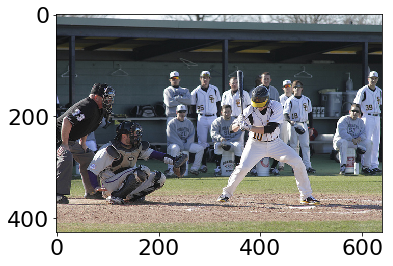

In [58]:
plt.imshow(IMAGE[...,::-1])
plt.show()

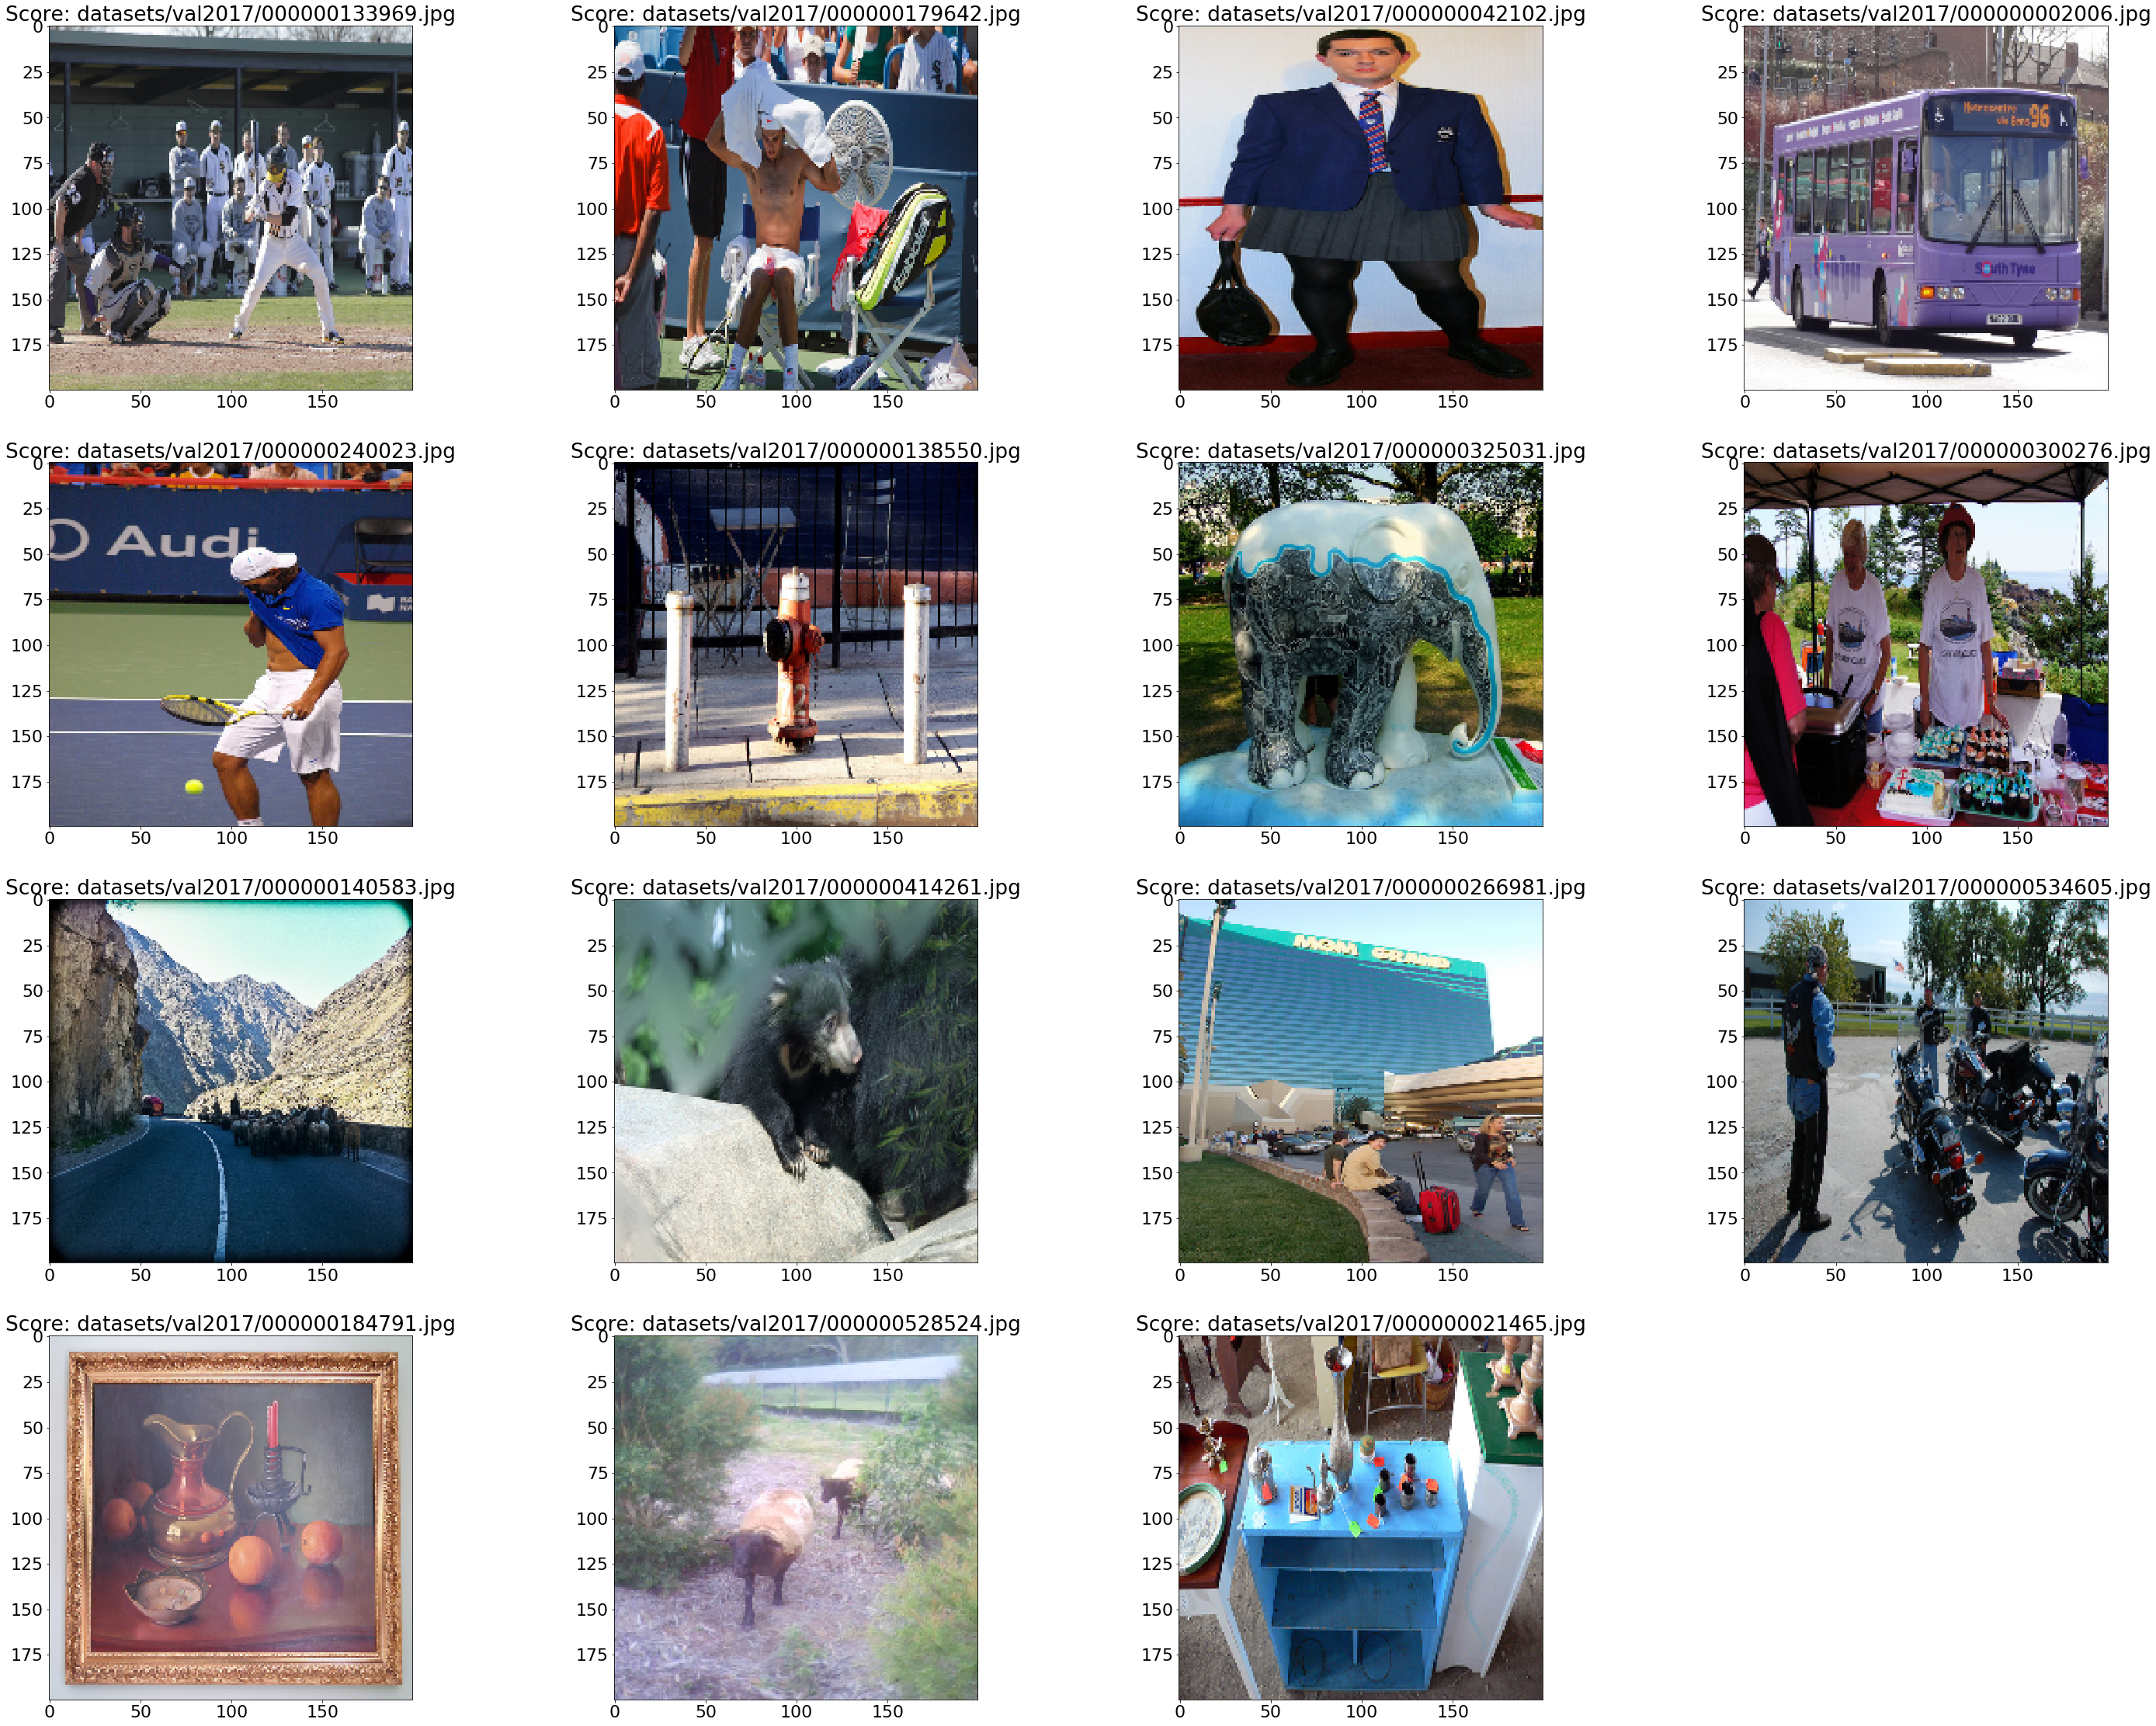

In [59]:
vis_cbir_results(IMAGE, images_combined, image_names_combined)

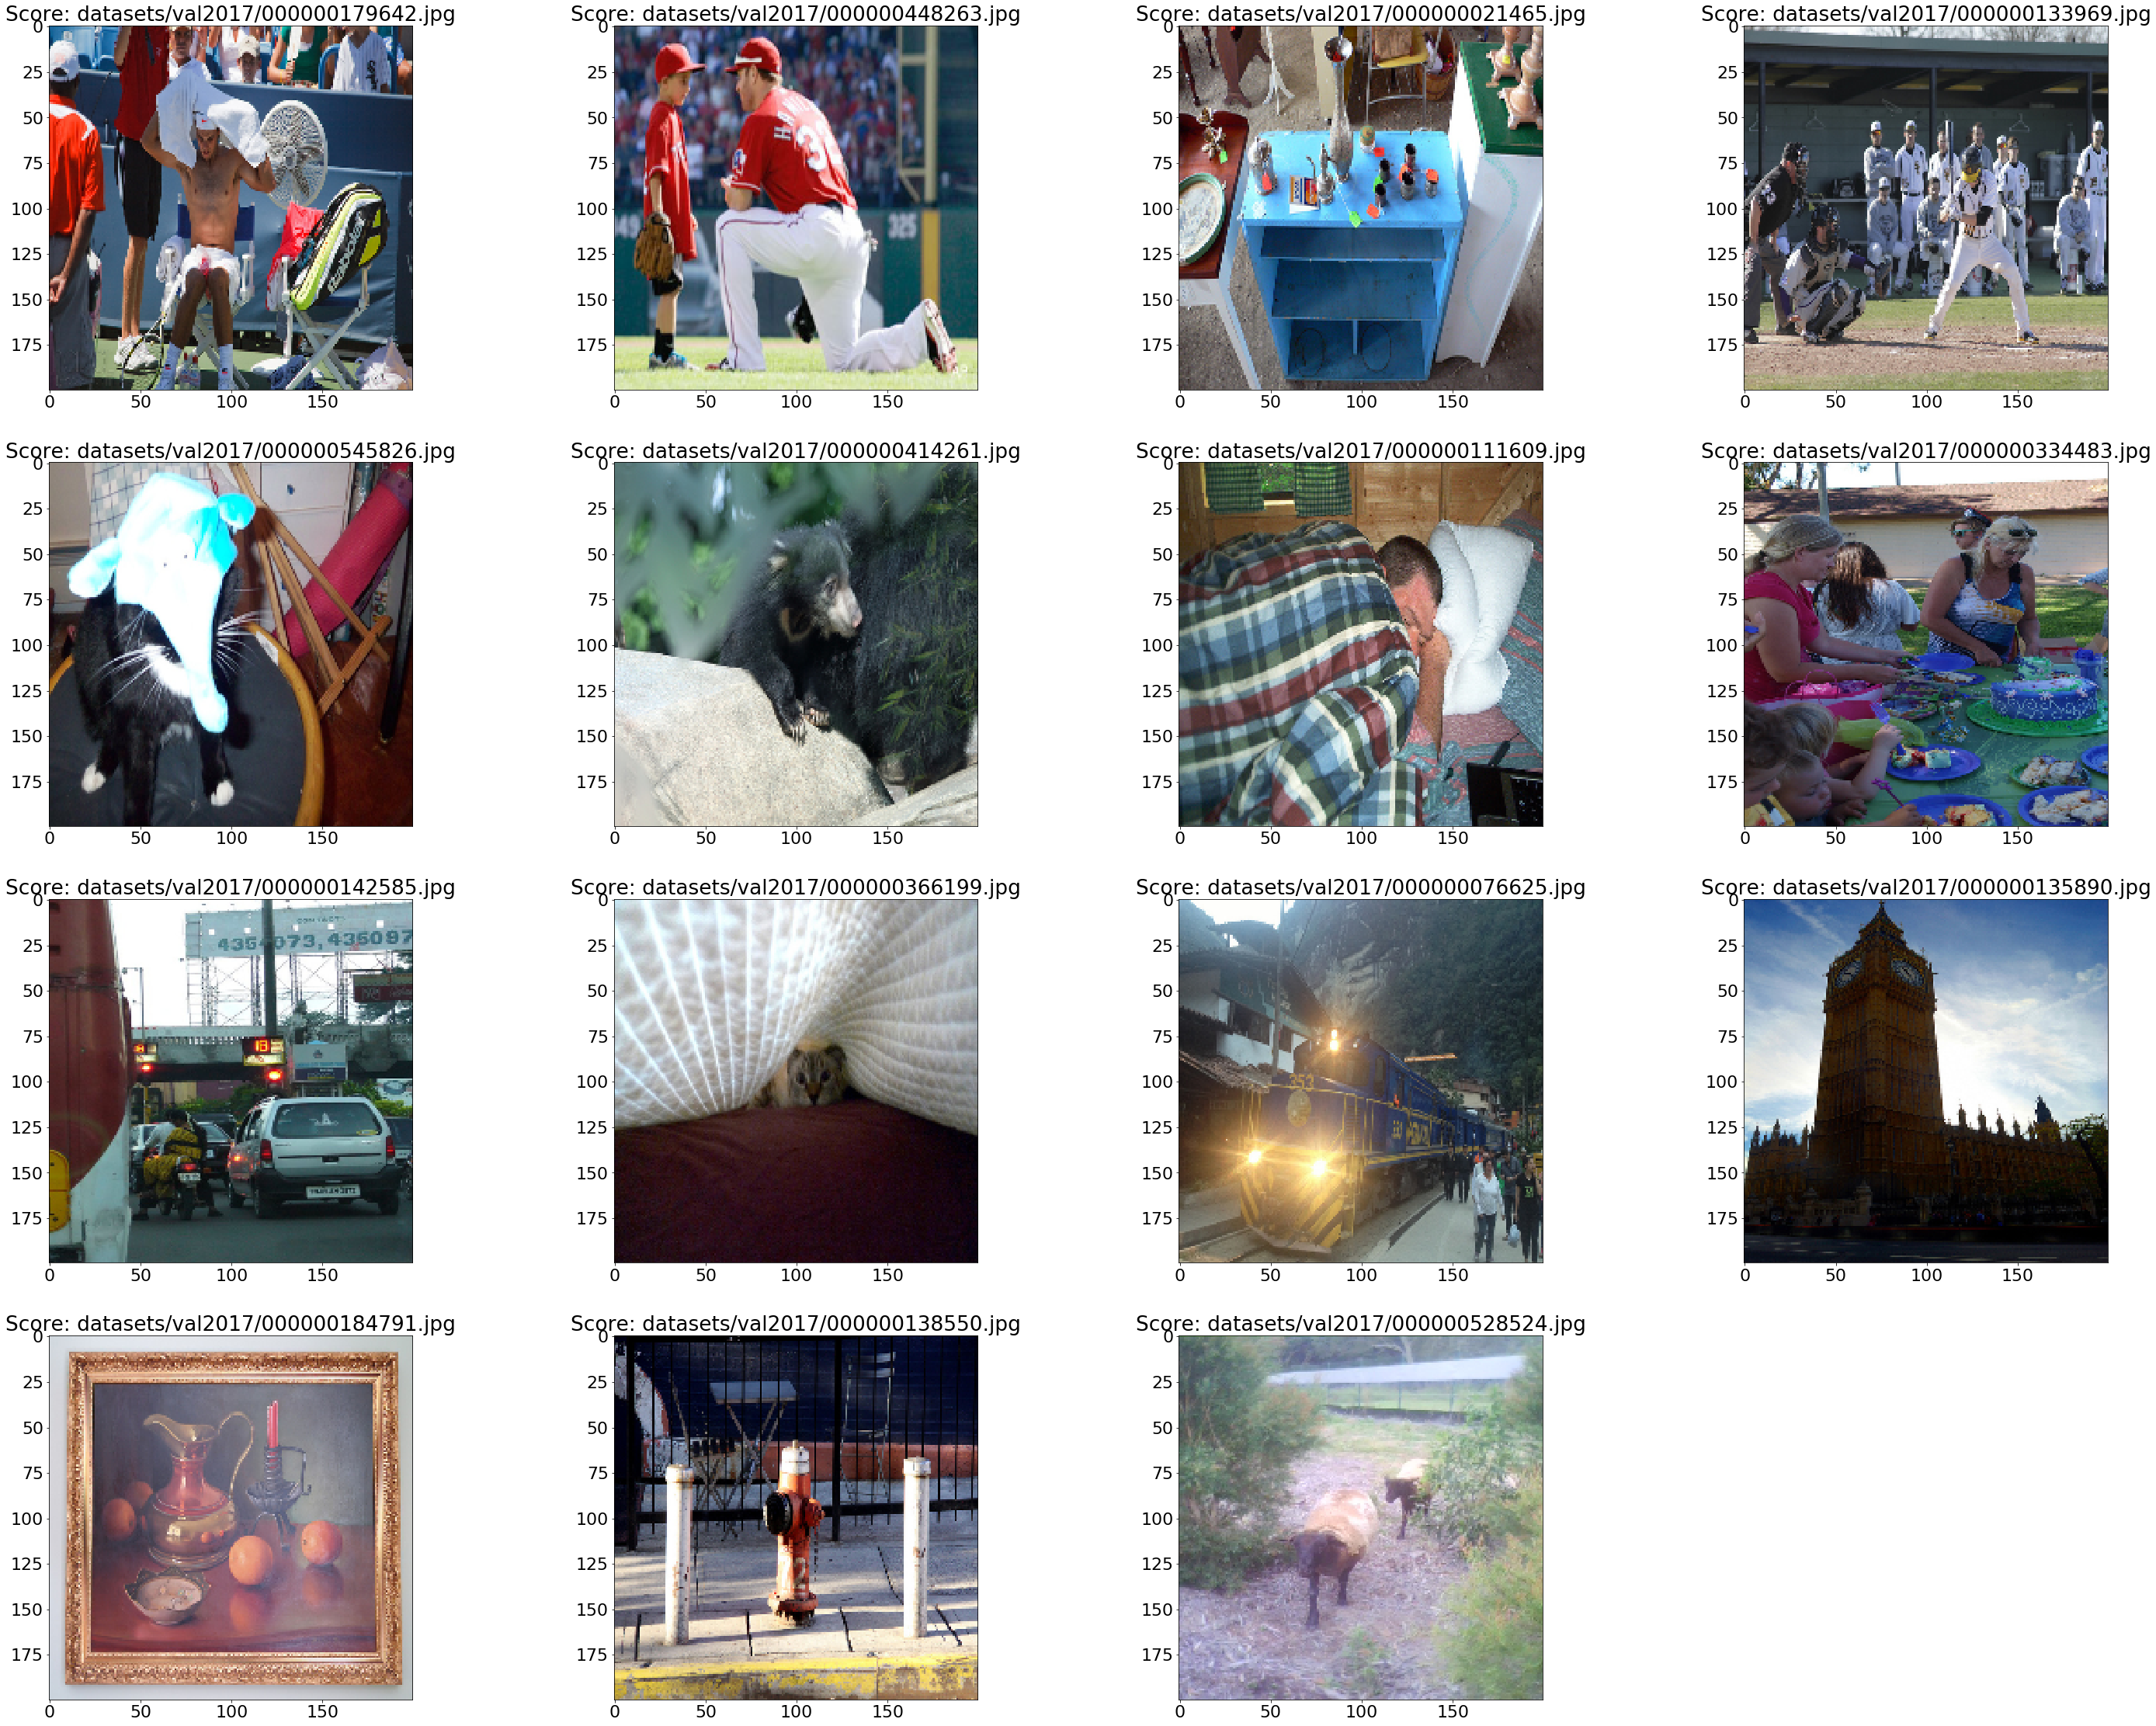

In [60]:
vis_cbir_results(IMAGE, images_ex_combined, image_names_ex_combined)